## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, RNN, SimpleRNN

## Parameters

In [21]:
train_test_rate = 0.2
n_timestep = 3
n_feature = 6

## Load Dataset

In [2]:
dataset = pd.read_csv('processed_data/dataset.csv', index_col='date', parse_dates=True)
unnoise_dataset = pd.read_csv('processed_data/unnoise_dataset.csv', index_col='date', parse_dates=True)

In [3]:
dataset.head()

,Ttb,Tx,Tn,R,Utb,Un
date,,,,,,
2015-01-01,14.7,25.3,9.3,0.0,75.0,33.0
2015-01-02,13.9,23.5,7.5,0.0,75.8,37.0
2015-01-03,14.1,21.0,9.5,0.0,83.5,54.0
2015-01-04,16.5,18.8,14.6,0.0,88.3,83.0
2015-01-05,19.0,22.6,16.5,1.0,87.0,72.0


In [4]:
unnoise_dataset.head()

,Ttb,Tx,Tn,R,Utb,Un
date,,,,,,
2015-01-01,13.9,23.5,7.5,0.0,75.0,33.0
2015-01-02,14.1,23.5,9.3,0.0,75.8,37.0
2015-01-03,14.1,21.0,9.5,0.0,83.5,54.0
2015-01-04,16.5,21.0,14.6,0.0,87.0,72.0
2015-01-05,19.0,22.6,16.5,1.0,88.3,72.0


## Generate Dataset

### Scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()
scaled_unnoise_dataset = scaler.fit_transform(unnoise_dataset)

In [12]:
scaled_unnoise_dataset[:5]

array([[0.28979592, 0.49484536, 0.14893617, 0.        , 0.51546392,
        0.09722222],
       [0.29795918, 0.49484536, 0.22553191, 0.        , 0.53195876,
        0.15277778],
       [0.29795918, 0.40893471, 0.23404255, 0.        , 0.69072165,
        0.38888889],
       [0.39591837, 0.40893471, 0.45106383, 0.        , 0.7628866 ,
        0.63888889],
       [0.49795918, 0.46391753, 0.53191489, 1.        , 0.78969072,
        0.63888889]])

### Train-test split

In [49]:
def train_test_split(data, rate=0.3):
    idx = get_idx(data, rate)
    return np.array(data[:idx]), np.array(data[idx:])
def get_idx(data, rate=0.3):
    return int((1 - rate)*len(data))

In [15]:
train_set, test_set = train_test_split(data=scaled_unnoise_dataset, rate=train_test_rate)

In [16]:
train_set.shape, test_set.shape

((1753, 6), (439, 6))

### Timestep split

def timestep_split(data, n_step):
    X, y = [], []
    
    length = len(data)
    for i in range(length - n_step):
        end_idx = i + n_step
        seq_X = data[i:end_idx]
        seq_y = data[end_idx]
        X.append(seq_X)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [19]:
X_train, y_train = timestep_split(data=train_set, n_step=n_timestep)
X_test, y_test = timestep_split(data=test_set, n_step=n_timestep)

In [20]:
X_train.shape

(1750, 3, 6)

## Build model

In [23]:
model = Sequential()
model.add(SimpleRNN(units=128, activation='relu', input_shape=(n_timestep, n_feature), return_sequences=True))
model.add(SimpleRNN(units=128, activation='relu'))
model.add(Dense(units=n_feature, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 3, 128)            17280     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 50,950
Trainable params: 50,950
Non-trainable params: 0
_________________________________________________________________


## Train

In [28]:
model.compile(optimizer='adam', loss='mse')

In [26]:
path = 'model/model.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True)

In [29]:
model.fit(X_train, y_train, epochs=100, callbacks=[checkpoint], batch_size=4,
         validation_data=(X_test, y_test), validation_batch_size=4)

Epoch 1/100
438/438 [==============================] - 3s 3ms/step - loss: 0.0479 - val_loss: 0.0425
Epoch 2/100
438/438 [==============================] - 1s 3ms/step - loss: 0.0395 - val_loss: 0.0354
Epoch 3/100
438/438 [==============================] - 1s 3ms/step - loss: 0.0373 - val_loss: 0.0354
Epoch 4/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0347 - val_loss: 0.0356
Epoch 5/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0346 - val_loss: 0.0346
Epoch 6/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0335 - val_loss: 0.0354
Epoch 7/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0326 - val_loss: 0.0329
Epoch 8/100
438/438 [==============================] - 1s 3ms/step - loss: 0.0325 - val_loss: 0.0359
Epoch 9/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0327 - val_loss: 0.0334
Epoch 10/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0321 - val_lo

438/438 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0394
Epoch 82/100
438/438 [==============================] - 1s 3ms/step - loss: 0.0210 - val_loss: 0.0389
Epoch 83/100
438/438 [==============================] - 1s 3ms/step - loss: 0.0207 - val_loss: 0.0402
Epoch 84/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0390
Epoch 85/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0206 - val_loss: 0.0384
Epoch 86/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0203 - val_loss: 0.0388
Epoch 87/100
438/438 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0384
Epoch 88/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0203 - val_loss: 0.0388
Epoch 89/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0398
Epoch 90/100
438/438 [==============================] - 1s 2ms/step - loss: 0.0199 - val_loss: 

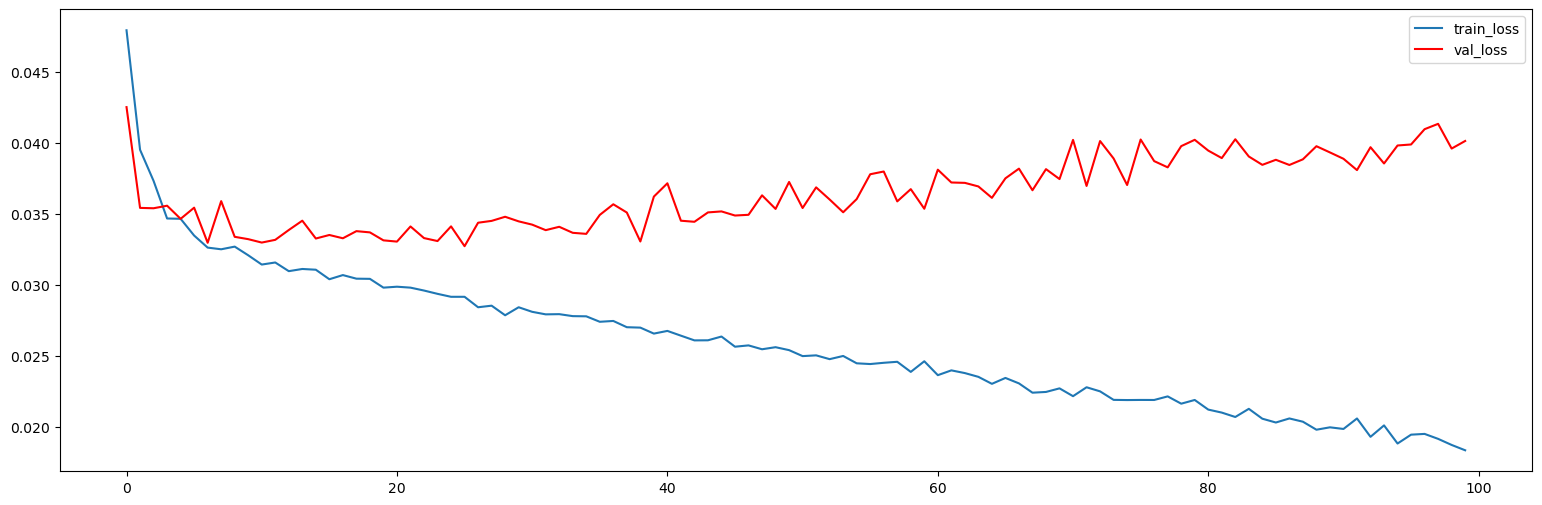

In [31]:
plt.figure(figsize=(19, 6))
plt.plot(model.history.history['loss'], label='train_loss')
plt.plot(model.history.history['val_loss'], c='red', label='val_loss')
plt.legend();

## Evaluate

In [32]:
#load best model
model = keras.models.load_model('model/model.h5')

In [72]:
#get predict
y_predict = model.predict(X_test)
y_predict = y_predict

y_predict = scaler.inverse_transform(y_predict)
y_unnoise = scaler.inverse_transform(y_test) #unnoised

Ttb_pred, Tx_pred, Tn_pred, R_pred, Utb_pred, Un_pred = y_predict[:,0], y_predict[:,1], y_predict[:,2], y_predict[:,3], y_predict[:,4], y_predict[:,5]

Ttb_unnoise, Tx_unnoise, Tn_unnoise, R_unnoise, Utb_unnoise, Un_unnoise = y_unnoise[:,0], y_unnoise[:,1], y_unnoise[:,2], y_unnoise[:,3], y_unnoise[:,4], y_unnoise[:,5]


_, y_real_test = train_test_split(data=dataset, rate=train_test_rate)
Ttb_real, Tx_real, Tn_real, R_real, Utb_real, Un_real = y_real_test[n_timestep:,0], y_real_test[n_timestep:,1], y_real_test[n_timestep:,2], y_real_test[n_timestep:,3], y_real_test[n_timestep:, 4], y_real_test[n_timestep:,5]#%%

14/14 [==============================] - 0s 2ms/step


In [62]:
y_predict[:5]

array([[25.704683  , 29.994938  , 23.001297  ,  0.58225363, 86.24893   ,
        73.56756   ],
       [26.038805  , 29.914572  , 23.549837  ,  0.7029854 , 86.49839   ,
        75.08191   ],
       [22.931404  , 26.16676   , 21.226915  ,  0.7968998 , 87.293526  ,
        76.4901    ],
       [23.797953  , 27.896065  , 21.641598  ,  0.58298445, 86.93888   ,
        73.66705   ],
       [25.16154   , 29.884096  , 22.524654  ,  0.45438597, 86.41725   ,
        71.17593   ]], dtype=float32)

### Ttb (Nhiệt độ trung bình)

In [34]:
from keras.metrics import mean_squared_error

In [43]:
# mean square error
Ttb_mse_1 = np.array(mean_squared_error(Ttb_unnoise, Ttb_pred))# compare with unnoise_dataset
Ttb_mse_2 = np.array(mean_squared_error(Ttb_real, Ttb_pred))# compare with real dataset
print(Ttb_mse_1, Ttb_mse_2)

1.51151 1.7805753


In [50]:
idx = get_idx(dataset, train_test_rate) + n_timestep

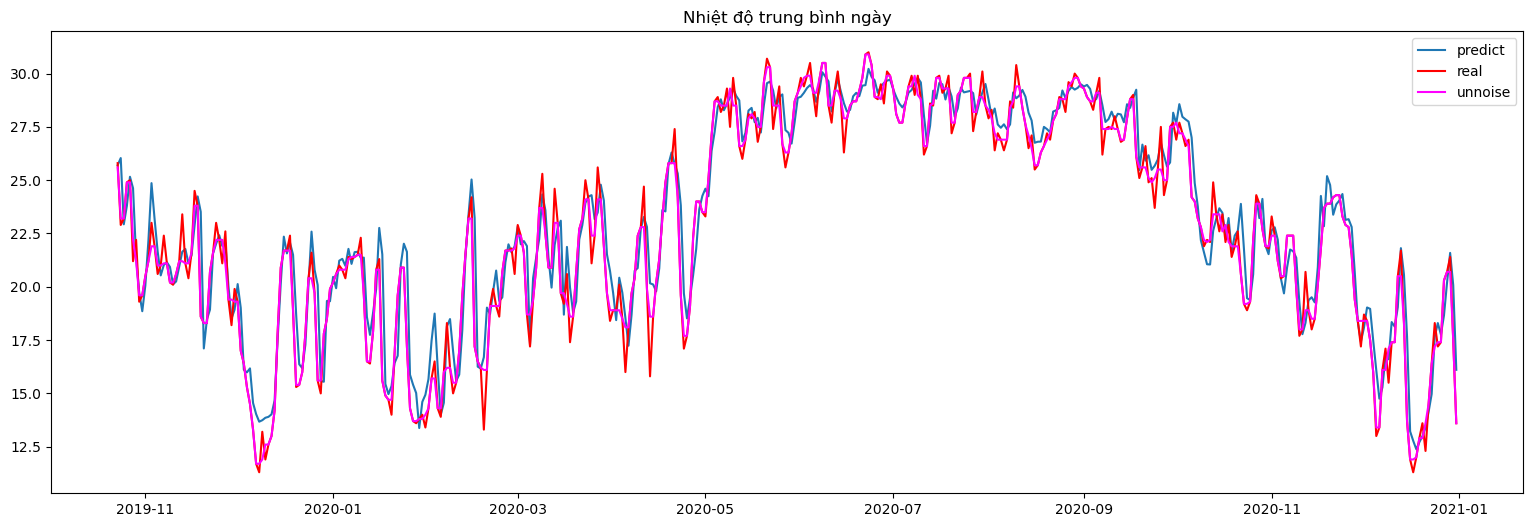

In [78]:
#visualization
plt.figure(figsize=(19,6))
plt.plot(dataset[idx:].index, Ttb_pred, label='predict')
plt.plot(dataset[idx:].index, Ttb_real, c='red', label='real')
plt.plot(dataset[idx:].index, Ttb_unnoise, c='magenta', label='unnoise')
plt.title('Nhiệt độ trung bình ngày')
plt.legend();

### Utb ( độ ẩm trung bình)

In [74]:
# mean square error
Utb_mse_1 = np.array(mean_squared_error(Utb_unnoise, Utb_pred))# compare with unnoise_dataset
Utb_mse_2 = np.array(mean_squared_error(Utb_real, Utb_pred))# compare with real dataset
print(Utb_mse_1, Utb_mse_2)

17.52761 25.16788


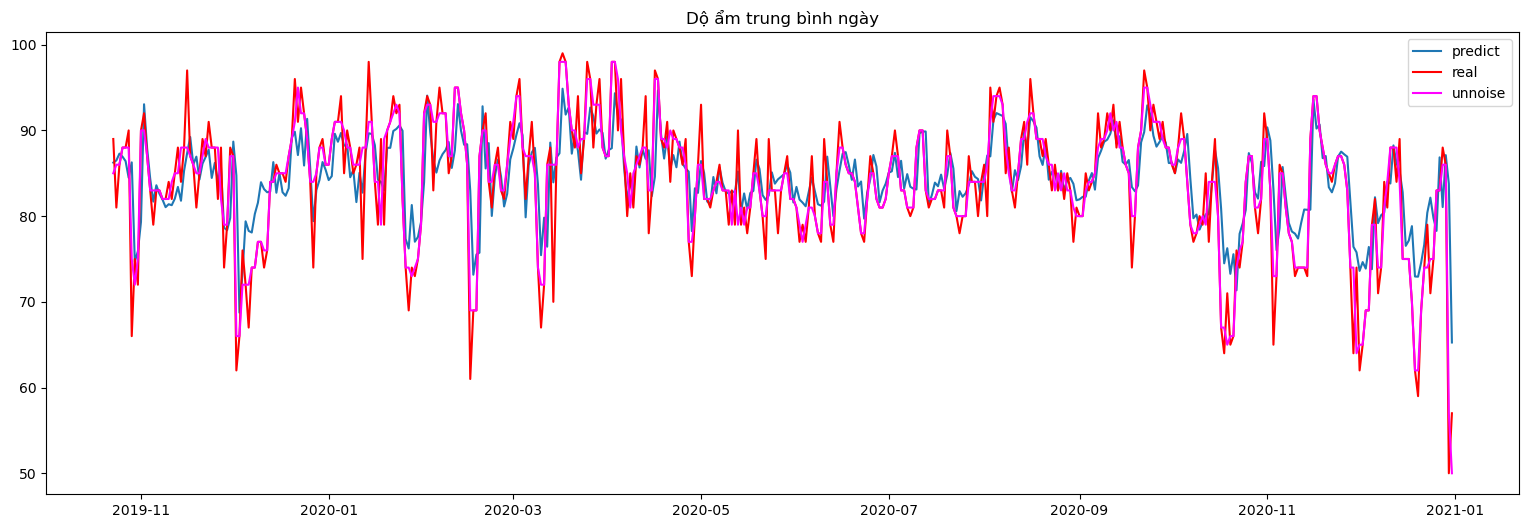

In [83]:
#visualization
plt.figure(figsize=(19,6))
plt.plot(dataset[idx:].index, Utb_pred, label='predict')
plt.plot(dataset[idx:].index, Utb_real, c='red', label='real')
plt.plot(dataset[idx:].index, Utb_unnoise, c='magenta', label='unnoise')
plt.title('Dộ ẩm trung bình ngày')
plt.legend();

### R (lượng mưa)

In [87]:
BA = keras.metrics.BinaryAccuracy(threshold=0.5)
BA.update_state(R_real, R_pred)
R_Accuracy = BA.result().numpy()
print(f'Độ chính xác khi dự đoán mưa hay không:{R_Accuracy*100}%')

Độ chính xác khi dự đoán mưa hay không:75.91742873191833%
